In [1]:
import numpy as np

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.mixture_gaussian import emfit

from gradvi.inference import LinearRegression, Trendfiltering
from gradvi.normal_means import NormalMeans, NormalMeansFromPosterior
from gradvi.tests import toy_priors, toy_data
from gradvi.optimize import moving_average as gvma
from gradvi.models import basis_matrix as gvbm
from gradvi.models import TrendfilteringModel

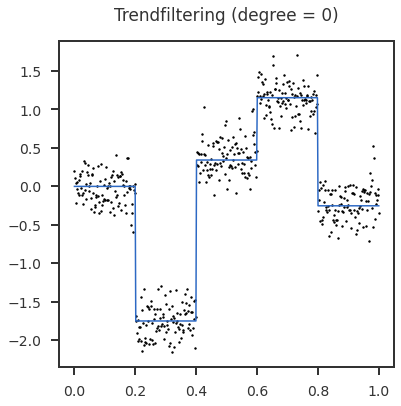

In [2]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degree = 0
nknots = 4
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)
fig = plt.figure(figsize = (6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x, data.y, s = 2, color = 'black')
ax.plot(data.x, data.ytrue)
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

plt.show()

In [6]:
s2_true = np.var(data.y - data.ytrue)

H = gvbm.trendfiltering(n, degree)
Hinv = gvbm.trendfiltering_inverse(n, degree)

prior = toy_priors.get_ash(k = 20, sparsity = 0.999, skbase = 2.0, skfactor = 1.0)
wtrue = emfit(np.dot(Hinv, data.ytrue), prior.sk)
prior.update_w(wtrue)

In [7]:
'''
Get oracle ELBO from mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(H, data.y, prior.sk,
            binit = np.dot(Hinv, data.ytrue), winit = wtrue, s2init = s2_true,
            update_pi = False, update_sigma2 = False)

mrash_ypred = np.dot(H, mrash_r.coef) + mrash_r.intercept
oracle_elbo = mrash_r.elbo_path[-1]

Mr.ASH terminated at iteration 16.


In [8]:
tf_y, tf_fit = R_trendfilter.fit(data.y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



### Optimize coefficients only

In [9]:
data.Hinv

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [10]:
data.H

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [11]:
Hscale = gvbm.trendfiltering_scaled(n, degree)
Hinv_scale = gvbm.trendfiltering_inverse_scaled(n, degree)

In [17]:
np.linalg.det(Hinv)

1.0

In [12]:
from scipy import optimize as sp_optimize

def fun1_tf_analysis(params, y, D, degree, prior, sj2, s2, dj, jac = True):
    n = y.shape[0]
    x = params[:n]
    
    #b0 = np.dot(D, x)
    b = np.zeros_like(x)
    b[degree + 1:] = np.diff(x, n = degree + 1)
    for i in range(degree + 1):
        b[i] = np.diff(x[:i+1], n = i)
    
    nm = NormalMeans(b, prior, sj2, scale = s2, d = dj)
    Mb, dMdb, dMdw, dMds2 = nm.shrinkage_operator(jac = True)
    Pb, dPdb, dPdw, dPds2 = nm.penalty_operator(jac = True)
    
    r = y - Mb
    rTr = np.sum(np.square(r))
    
    obj = (0.5 * rTr / s2) + np.sum(Pb)
    if jac:
        grad = - (r * dMdb / s2) + dPdb #np.dot(D.T, dPdb)
        return obj, grad
    return obj


y_init = gvma.moving_average(data.y)
#y_init = tf_y.copy()
#y_init = data.y.copy()
#dj  = np.sum(np.square(Hscale), axis = 0)
dj = np.ones(n)
#dj = np.sum(np.square(H), axis = 0)
sj2 = s2_true / dj
maxiter = 20000

opt_min = sp_optimize.minimize(fun1_tf_analysis, y_init,
            args = (data.y, data.Hinv, degree, prior, sj2, s2_true, dj),
            method = 'l-bfgs-b', 
            jac = True,
            #options = {'disp': True, 'maxiter': 10, 'return_all': True}
            options = {'disp':False, 'maxiter': maxiter})

In [28]:
print(opt_min.nit)

model = NormalMeans(opt_min.x, prior, sj2, scale = s2_true, d = dj)
ypred = model.shrinkage_operator(jac = False)
bhat  = np.dot(Hinv, ypred)

10


In [29]:
ypred

array([ 9.70504101e-05,  8.20563837e-05,  5.96698340e-05, -5.88615099e-05,
        1.12715787e-05,  7.03182719e-05,  1.45817070e-05,  7.73558778e-05,
       -2.51515695e-06,  1.19665241e-04,  1.32749919e-04,  8.54540687e-05,
        4.59982956e-05,  1.64776183e-04,  3.08896869e-05, -4.38909648e-05,
        1.60526335e-04,  1.74950858e-04,  3.88476899e-05, -1.09642245e-05,
        8.29567298e-05,  1.28456069e-04,  9.47156869e-05,  1.22872889e-04,
       -2.92093213e-05, -1.01846624e-05,  6.33850339e-06, -1.44350928e-04,
       -7.17141565e-05,  4.78204559e-05,  1.53937107e-05, -9.91972188e-05,
        1.08029841e-05, -2.14618956e-04, -1.88682749e-04, -2.01893722e-04,
       -1.61310511e-04, -2.10021060e-04, -1.45397166e-04, -1.97929353e-04,
       -4.22711149e-05, -3.11873806e-04, -1.97054528e-04, -9.24711175e-05,
       -3.34395583e-04, -2.70489424e-05, -2.89378661e-04, -1.94134188e-04,
       -2.32553527e-04, -2.18583984e-04, -1.13014678e-04, -6.09503440e-05,
       -1.61678553e-04,  

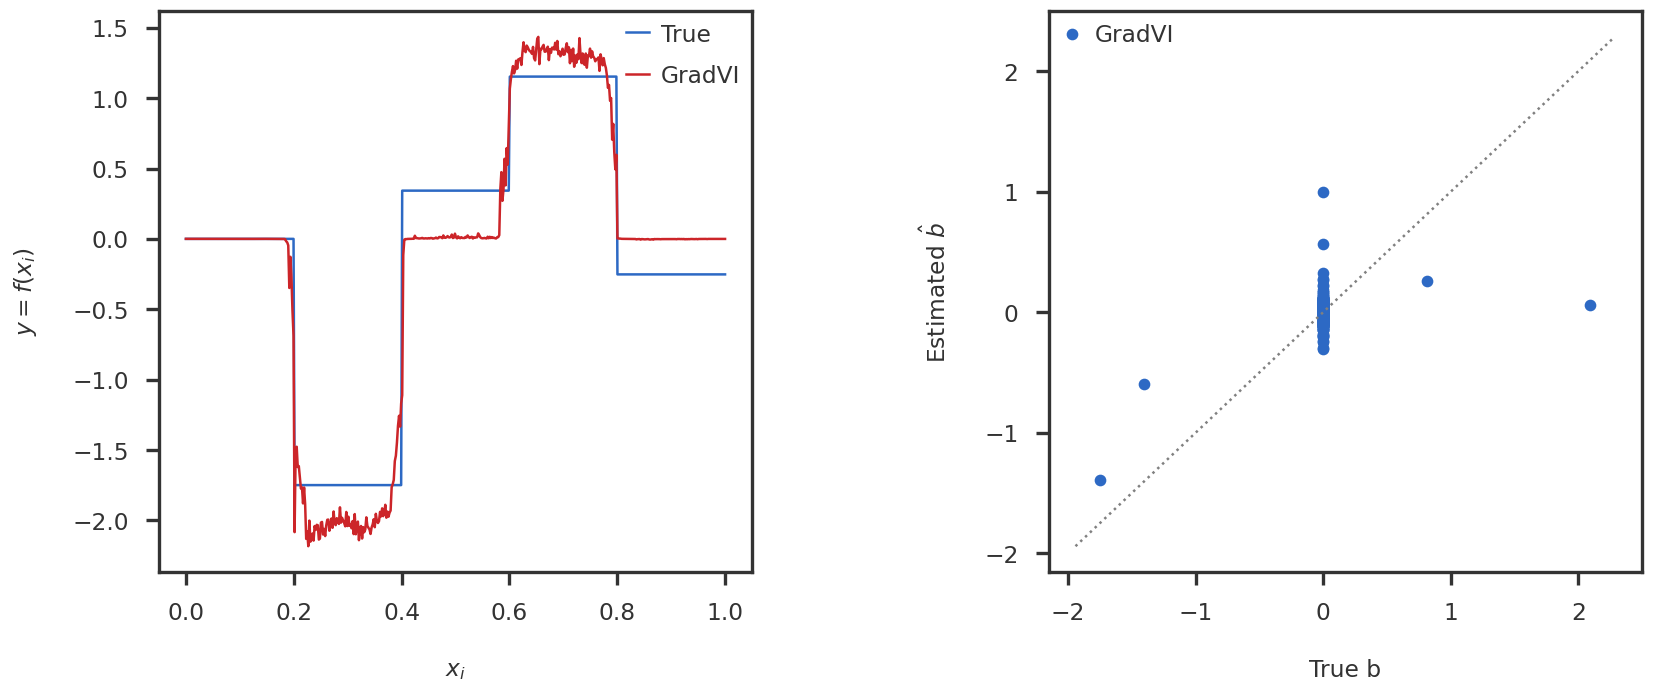

In [30]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
#ax1.scatter(x, data.y, s = 5, edgecolor = 'black', facecolor='white', alpha = 0.2)
ax1.plot(x, data.ytrue, label = "True")
#ax1.plot(x, y_init, label = "Initial")
#ax1.plot(x, tf_y, label = "Genlasso")
ax1.plot(x, ypred, label = "GradVI")
ax1.legend()
ax1.set_xlabel(r"$x_i$")
ax1.set_ylabel(r"$y = f(x_i)$")


ax2.scatter(data.btrue, bhat, label = "GradVI")

ax2.set_xlabel("True b")
ax2.set_ylabel(r"Estimated $\hat{b}$")
ax2.legend()

mpl_utils.plot_diag(ax2)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5)
plt.show()

In [ ]:
# '''
# GradVI Trendfiltering
# '''
# def fun1(params, y, A, prior, sj2, s2, dj, jac = True):
#     n = y.shape[0]
#     k = prior.k
#     x = params[:n]
#     a = params[n:]
#     prior.update_wmod(a)
    
#     r = y - x
#     rTr = np.dot(r, r)
    
#     #sj2 = s2 / dj
#     b = np.dot(A, x)
#     nm = NormalMeansFromPosterior(b, prior, sj2, scale = s2, d = dj, method = 'newton')
#     Pb, dPdb, dPdw, dPds2 = nm.penalty_operator(jac = True)
    
#     h = (0.5 * rTr / s2) + np.sum(Pb)
#     #h = np.sum(Pb)
#     if jac:
#         dhdx = - r / s2 + np.dot(A.T, dPdb)
#         #dhdx = np.dot(A.T, dPdb)
#         dhdw  = np.sum(dPdw, axis = 0)
#         dhda  = prior.wmod_grad(dhdw)
#         return h, np.concatenate((dhdx, dhda))
#     return h